In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Addmisions

In [ ]:
addmissions = pd.read_csv('/content/drive/MyDrive/research/research/hosp/admissions.csv')

def categorize_strings(str_list):
    categories = {string: 'EMERGENCY' if ('EMER' or 'URGENT') in string else 'OBSERVATION' if 'OBSERV' in string else None for string in str_list}
    categories = {k: v for k, v in categories.items() if v is not None}
    return categories

def proccess_addmision(admits):
    '''
        at the moment there where are still many values in the race catagory, if we want to change use the next code snippet

    '''
    return (
            admits
            [['subject_id','hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'insurance','marital_status' ,'race']]
            .assign(admittime = pd.to_datetime(admits['admittime']),
                    dischtime = pd.to_datetime(admits['dischtime']),
                    deathtime = pd.to_datetime(admits['deathtime']),
                    died_at_the_hospital = admits['hospital_expire_flag'],
                    race = admits['race'].replace({'UNKNOWN':'other/unknown','UNABLE TO OBTAIN':'other/unknown','OTHER':'other/unknown'}),
                    admission_type = admits['admission_type'].replace(categorize_strings(admits['admission_type'].value_counts().index.tolist())))
           )
    
addmissions = proccess_addmision(addmissions)

In [ ]:
# TODO: check if relveant
import re
def LowerRaceCardinality(df,Limit=None):
  '''
  input = given a df and limit of how many wanted catagories wanted

  output = reduce the amount of catagories in the df

  '''
  repl_dict = {re.compile('^ASIAN\D*'): 'ASIAN',
                re.compile('^WHITE\D'): 'WHITE',
                re.compile('^HISPANIC\D'): 'HISPANIC/LATINO',
                re.compile('^BLACK\D'): 'BLACK/AFRICAN AMERICAN'}
  df['race'] = df['race'].replace(repl_dict, regex=True)

  if Limit != None:
    df['race'] = df['race'].loc[~df['race'].isin(df['race'].value_counts().nlargest(Limit).index.tolist())] = 'OTHER/UNKNOWN'  
  

  return df

# # Compress the number of ethnicity categories
# admits['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
# admits['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
# admits['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
# admits['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
# admits['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
#                          'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
# #take into consideration just the top-5 categories with biggest value_count, the others will fall into OTHER category
# admits['ethnicity'].loc[~admits['ethnicity'].isin(admits['ethnicity'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'  
# admits['ethnicity'].value_counts()

#Patients

In [ ]:
patients = pd.read_csv('/content/drive/MyDrive/research/research/hosp/patients.csv')

def proccess_patients(patients):
    return (
            patients
            [['subject_id', 'gender', 'anchor_age', 'dod']]
            .assign(dod  = pd.to_datetime(patients['dod']),
                    is_male = np.where(patients['gender'] == 'M',1,0))
            .drop('gender',axis=1)
            .query('anchor_age > 0 ')  #removes children
           )
patients = proccess_patients(patients)

In [ ]:
admits_patients = pd.merge(addmissions, patients, how='inner', on='subject_id')

#Diagnoses_icd

In [ ]:
diagnoses_icd = pd.read_csv('/content/drive/MyDrive/research/research/hosp/diagnoses_icd.csv')

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
              4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
              8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
              12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
              16: 'injury and poisoning', 17: 'misc'}

def recoder(diag):
  # ICD-9 Main Category ranges
  icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
                (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
                (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

  # Re-code in terms of integer
  for num, cat_range in enumerate(icd9_ranges):
      diag['recode'] = np.where(diag['recode'].between(cat_range[0],cat_range[1]), num, diag['recode'])
  
  return diag['recode']


def proccess_diagnoses_icd(diag):
    '''
    information about the icd cats where taken from here - https://en.wikipedia.org/wiki/List_of_ICD-9_codes

    '''
    return (
            diag
            .query('icd_version == 9')
            .assign(recode = diag['icd_code'][~diag['icd_code'].str.contains("[a-zA-Z]").fillna(False)])
            .assign(recode = lambda d:(
                                        d['recode']
                                       .str
                                       .slice(start=0, stop=3, step=1)
                                       .fillna(999)
                                       .astype(int)
                                       ))
            .assign(recode = lambda d:recoder(d))
            .assign(icd_catagory = lambda d:d['recode'].replace(diag_dict))
          )
diag = proccess_diagnoses_icd(diagnoses_icd)

In [ ]:
'''
for each hadm_id visit get a count for how many diag codes from the same catagory that patient recieved
'''

hadm_list = ( 
              diag
             .groupby('hadm_id')
             ['icd_catagory']
             .apply(list)
             .reset_index()
            ) 

hadm_item = (
            pd.get_dummies(
                           hadm_list['icd_catagory']
                           .apply(pd.Series)
                           .stack()
                          )
            .groupby(level=0)
            .sum()
            .pipe(lambda d:d.join(hadm_list['hadm_id'], how="outer"))
            )

admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='hadm_id')


In [ ]:
admits_patients_diag['hadm_id']

0         22595853
1         22841357
2         25742920
3         29079034
4         25022803
            ...   
291809    27638769
291810    27674281
291811    21033226
291812    26071774
291813    23865745
Name: hadm_id, Length: 291814, dtype: int64

In [ ]:
# admits_patients_diag.to_csv('admits_patients_diag.csv')

In [ ]:
print(f'''
      Number of missing date admissions: {admits_patients_diag.admittime.isnull().sum()}
      Number of missing date discharges: {admits_patients_diag.dischtime.isnull().sum()}
      ''')


      Number of missing date admissions: 0
      Number of missing date discharges: 0
      


In [ ]:
def NonElective(df):
  '''
  as we are only interested about patients that were readdmited in a non elective manner
  change the information in those rows to null
  '''
  elective_rows = df['next_admission_type'] == 'ELECTIVE'
  df.loc[elective_rows,'next_admittime'] = np.NaN
  df.loc[elective_rows,'next_admission_type'] = np.NaN
  return df

def NextAdmitAfterElective(df):
  '''
  using the bfill method for rows with null values in the next admission type with

  '''
  df[['next_admittime','next_admission_type']] = (
                                                   df
                                                  .groupby(['subject_id'])
                                                  [['next_admittime','next_admission_type']]
                                                  .fillna(method = 'bfill')
                                                  )
  
  return df

def AddAgeGroup(df):
  '''
  adding a grouping system for ages
  '''
  
  age_ranges = [(0, 2),(3,9),(10,19), (20, 36), (37, 56), (57, 100)]
  df['anchor_group'] = df['anchor_age']
  for num, cat_range in enumerate(age_ranges):
      df['anchor_group'] = np.where(df['anchor_group'].between(cat_range[0],cat_range[1]), num, df['anchor_group'])

  age_dict = {0: 'NEWBORN', 1: 'KID', 2: 'TEEN',3:'YOUNG-ADULT',4:'MIDDLE_ADULT', 5: 'SENIOR'}
  df['anchor_group'] = df['anchor_group'].replace(age_dict)

  return df



In [ ]:
admits_patients_diag =   (
                          admits_patients_diag
                          .sort_values(['subject_id','admittime'])
                          .assign(next_admittime = lambda d:d.groupby('subject_id').admittime.shift(-1),
                                  next_admission_type = lambda d:d.groupby('subject_id').admission_type.shift(-1))
                          .pipe(lambda d:NonElective(d))
                          .pipe(lambda d:NextAdmitAfterElective(d))
                          .assign(days_until_next_admit = lambda d: (d['next_admittime'] - d['dischtime']).dt.total_seconds()/(24*60*60))
                          .pipe(lambda d:AddAgeGroup(d))

                         )

#icustays

In [ ]:
icustays = pd.read_csv('/content/drive/MyDrive/research/research/ICU/icustays.csv')

In [ ]:
icu_list = (
            icustays
            .rename(columns={'first_careunit':'category'})
            .groupby('hadm_id')
            ['category']
            .apply(list)
            .reset_index()
           )

In [ ]:
icu_item = (
            pd.get_dummies(
                            icu_list['category']
                          .apply(pd.Series)
                          .stack()
                          )
          .groupby(level=0)
          .sum()
          .pipe(lambda d: (d>=1).astype(int))
          .pipe(lambda d: d.join(icu_list['hadm_id'], how="outer"))
        )

In [ ]:
def fill_na_last(df, numberofcolumns):
  df.iloc[:, -numberofcolumns:] = df.iloc[:, -numberofcolumns:].fillna(0)
  return df 

df4 = (
        admits_patients_diag
       .merge(icu_item, how='inner', on='hadm_id')
       .pipe(lambda d:fill_na_last(d,9))
      )

#chartsevent

this operation was done on a server with higher ram



```
charts = pd.read_csv(...)

vital_dict = {220045: 'Heart Rate',
              220210: 'Respiratory Rate',
              220277: 'O2 saturation pulseoxymetry',
              220048: 'Heart Rhythm',
              224650: 'Ectopy Type 1',
              220179: 'Non Invasive Blood Pressure systolic',
              220180: 'Non Invasive Blood Pressure diastolic',
              220181: 'Non Invasive Blood Pressure mean'}


def group_vitals(group):
    # Create a new DataFrame with the hadm_id and a list of all the itemid values
    return pd.DataFrame({'hadm_id': group['hadm_id'].iloc[0], 'itemids': [group['itemid'].tolist()],
                         'values': [group['value'].tolist()] })
                        

grouped = (
            charts
            .query('itemid in @vital_list_codes')
            .groupby('hadm_id')
            .apply(group_vitals)
            .reset_index(drop=True)
          )


df4 = df4.merge(grouped,on='hadm_id')
vital_sign_results = df4.apply(lambda row: {vital_dict[item]: value for item, value in zip(row["itemids"], row["values"]) if item in list(vital_dict.keys())}, axis=1)
unpacked = pd.DataFrame.from_records(vital_sign_results.tolist())
unpacked.columns = ['first_' + col for col in temp.columns]
df5 = df4.join(temp)
```



In [ ]:
df5 = pd.read_csv('/content/drive/MyDrive/after_vitals.csv',parse_dates=['admittime','dischtime','deathtime','next_admittime'])

def change_columns_to_int(df,startCol,EndCol):
    df.iloc[:, startCol:EndCol] = df.iloc[:, startCol:EndCol].astype(int)
    return df

def fix_df5(df5):
    return (
            df5
            .drop(df5.columns[df5.columns.str.contains('unnamed',case = False)],axis = 1)
           )

df5 = fix_df5(df5)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,8,9,10,13,33,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# def final_dummies(df):
#   prefix_cols = ['ADM', 'INS','MS','RACE', 'AGE','HR','ECTO']
#   dummy_cols = ['admission_type', 'insurance','marital_status','race', 'anchor_group','first_Heart Rhythm','first_Ectopy Type 1'] 
#   return pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)


In [ ]:
final_df = (
            df5
            .query('died_at_the_hospital == 0.0')
            # .pipe(final_dummies)
            .drop(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime','dod', 'died_at_the_hospital','next_admittime'],axis=1)
            .dropna(axis=0)
            .assign(READMISSION_30 = lambda d:(d.days_until_next_admit < 30).astype('int'),
                    READMISSION_90 = lambda d:(d.days_until_next_admit < 90).astype('int'),
                    READMISSION_365 = lambda d:(d.days_until_next_admit < 365).astype('int'))
            .pipe(lambda d:d.drop('days_until_next_admit',axis=1))      
            )     

In [ ]:


print(f'''
      number of positive samples for 30 days: {(final_df.READMISSION_30 == 1).sum()}
      number of negative samples for 30 days: {(final_df.READMISSION_30 == 0).sum()}

      number of positive samples for 90 days: {(final_df.READMISSION_90 == 1).sum()}
      number of negative samples for 90 days: {(final_df.READMISSION_90 == 0).sum()}

      number of positive samples for 365 days: {(final_df.READMISSION_365 == 1).sum()}
      number of negative samples for 365 days: {(final_df.READMISSION_365 == 0).sum()}

      total number of samples: {len(final_df)}


      ''')



      number of positive samples for 30 days: 7583
      number of negative samples for 30 days: 9909

      number of positive samples for 90 days: 11184
      number of negative samples for 90 days: 6308

      number of positive samples for 365 days: 14932
      number of negative samples for 365 days: 2560

      total number of samples: 17492


      


In [ ]:
df = final_df.copy()
df = df.drop(['READMISSION_30','READMISSION_365'],axis=1)

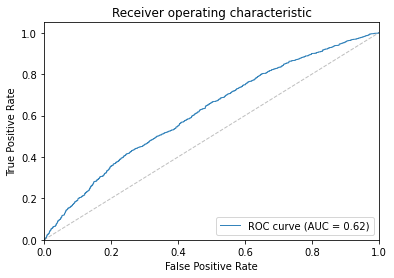

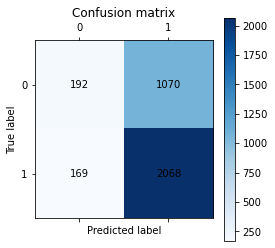

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data


# Encode any categorical features
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Split into features and target
X = df.drop('READMISSION_90', axis=1)
y = df['READMISSION_90']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Fit the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Predict probabilities for test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC curve (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Predict test set labels
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()
